<div style="border:solid Chocolate 2px; padding: 40px">

<b> Александр, привет!👋</b>

Меня зовут Кирилл Васильев, я буду ревьюером твоего проекта. Я предлагаю общаться на «ты», но если привычнее на «вы», просто скажи об этом! 

Я буду оставлять комментарии в твоем проекте. Пожалуйста, не удаляй их, они могут быть полезны в случае повторной проверки.

Ты можешь реагировать на комментарии как просто написав их в Markdown-ячейках, так и выделив их цветом. Например, <font color='blue'>синим</font>. Второй способ, на мой взгляд, удобнее.

Свои комментарии я буду обозначать <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В случае, если решение на отдельном шаге является полностью правильным. Здесь же я могу давать советы и предложения.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> В случае, когда решение на отдельном шаге станет еще лучше, если внести небольшие коррективы.
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
 В случае, когда решение на отдельном шаге требует существенной переработки и внесения правок. Напоминаю, что проект не может быть принят с первого раза, если ревью содержит комментарии, рекомендующие доработать шаги.
</div>
    
Увидев у тебя неточность, в первый раз я лишь укажу на ее наличие и дам тебе возможность самому найти и исправить ее. На реальной работе твой руководитель будет поступать также. Но если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку! 

### Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.  
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.   
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.  
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично. Есть описание проекта. Ясны цели и задачи.
</div>

In [1]:
pip install fast_ml


Note: you may need to restart the kernel to use updated packages.


### Импорт бибилиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    f1_score, recall_score, 
    precision_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix)
from sklearn.utils import shuffle

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь было бы идеально привести оформление в соответствие с <a href="https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html">pep8</a> - не оставлять длинных строк. 

Такое оформление предпочтительнее:    
    
`from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    mean_squared_error, 
    roc_auc_score
)`
    
<font color = blue> Поправил        
</div>


### Загрузка датасета

In [3]:
try:
    df = pd.read_csv('./datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* В столбце Tenure не хватает около 1000 строк
* 3 классовых столбца (object) остальные - числовые
* Rownumber, CustomerId, Surname для модели использовать не будем, т.к. это уникальные значения, не являющиеся характиристиками заемщика.
* Можно перевести столбец IsActiveMember в булевый формат

In [5]:
df['IsActiveMember']=df['IsActiveMember'].astype('bool') #Изменим тип данных на булевый, чтобы меньше нагружать пк.
df['Exited']=df['Exited'].astype('bool')
df['HasCrCard']=df['HasCrCard'].astype('bool')

In [6]:
df[df['Tenure'].isna()].head(10) #Есть смысл посмотреть другие столбцы, где Tenure = NA

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,True,False,140469.38,True
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,False,True,90878.13,False
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,False,False,86424.57,False
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,False,False,164040.94,True
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,False,False,84509.57,False
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,False,False,26019.59,False
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,True,True,114675.75,False
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,False,True,85982.47,False
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,False,False,6534.18,False
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,True,False,27231.26,False


Какой-либо закономерностей я тут не увидел. Поэтому построим гистограмму столбца Tenure

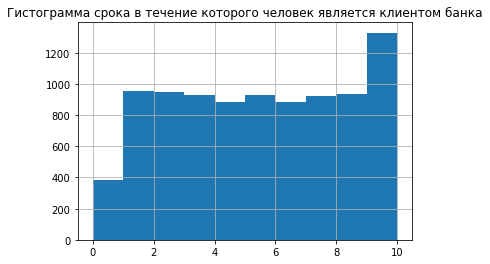

In [7]:
df['Tenure'].hist(bins = 10)
plt.title('Гистограмма срока в течение которого человек является клиентом банка')
plt.show()

Люди распределены довольно равномерно, чуть меньше людей только начали пользоваться банком и больше людей, которые уже 10 лет являются его клиентами.
Для начала заполним пропуски медианой, если этот способ не даст достаточной точности при построении модели, можно исопльзовать и другие варианты.

In [8]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Всё верно
</div>

In [9]:
df.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.00000,10000.000000,10000.000000,10000,10000,10000.000000,10000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,2,2,NaN,2
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,True,True,NaN,False
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,7055,5151,NaN,7963
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.99790,76485.889288,1.530200,NaN,NaN,100090.239881,NaN
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.76001,62397.405202,0.581654,NaN,NaN,57510.492818,NaN
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.00000,0.000000,1.000000,NaN,NaN,11.580000,NaN
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.00000,0.000000,1.000000,NaN,NaN,51002.110000,NaN
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.00000,97198.540000,1.000000,NaN,NaN,100193.915000,NaN
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.00000,127644.240000,2.000000,NaN,NaN,149388.247500,NaN


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично. Здесь можно передать аргументы, чтобы информация отображалась и по переменным с нечисленными типами данных.
      
`describe(include='all')`
    
Возможно, удобнее будет смотреть, если транспонировать таблицу.
<font color = blue> Спасибо, не знал, потестил</div>

* Первые 2 столбца нас не интересуют. Т.к. это идентификаторы, не содержащие полезной информации для модели.
* CreditScore потребует масштабирования как и другие числовые столбцы
* Явных аномалий на данной стадии не выявлено


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Супер. Будем считать это промежуточным выводом к предобработке. Я бы его только подвинул пониже.  
</div>

In [10]:
df.duplicated().sum()

0

* Явных дубликатов нет

### Подготовка данных для моделей

In [11]:
df_ml = df.drop(['RowNumber','CustomerId','Surname'],axis = 1) #Удаляем прядковые столбцы, которые не нужны в модели
df_ml = pd.get_dummies(df_ml, drop_first=True) #Преобразуем категориальные данные методом Ohe
features = df_ml.drop(['Exited'],axis=1)
target = df_ml['Exited']
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(
    df_ml, target = 'Exited', train_size=0.8, valid_size=0.1, test_size=0.1)#Разделим данные на 3 группы в соотношении 80-10-10
print ('Размеры полученных выборок:')
print("Тренировочная: ", X_train.shape,y_train.shape)
print("Валидационная: ",X_valid.shape,y_valid.shape)
print("Тестовая: ",X_test.shape,y_test.shape)

Размеры полученных выборок:
Тренировочная:  (8000, 11) (8000,)
Валидационная:  (1000, 11) (1000,)
Тестовая:  (1000, 11) (1000,)


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Как много событий сразу в одной ячейке. 
    
По энкодингу - круто, не попались в ловушку.
    
По разбиению. Я бы еще вывел shape получившихся выборок. По решению - я бы на тренировочную чуть больше заложил. Данных мало, лучше, если будем больше обучаться.
<font color = blue> Добавил shape</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

В тренажере давался пример использования прямого кодирования с помощью get_dummies, однако это далеко не самый оптимальный вариант. Он подходит для анализа данных, но в машинном обучении может служить причиной ошибок при обучении моделей.
    
Предлагаю тебе использовать класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">OHE из sklearn</a>. Он точно понадобится в будущих проектах, можно потренироваться сейчас. 

Практикум подготовил инструкцию, как использовать OHE: https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing 

А теперь замечания «под звездочкой»:

Есть загвоздка, что нам нужно будет одновременно использовать параметры drop='first' и handle_unknown='ignore’.  в OHE, а на платформе такое сочетание может выдавать ошибку (в части случаев). Если ошибка появляется, необходимо загрузить нужную версию сайкит-лерна. Для этого:

1. В отдельной строке в самом начале проекта запускаем такую команду:
 `!pip install scikit-learn==1.1.3`
     
2. Находим в меню юпитера кнопку `Kernel`, нажимаем и выбираем Restart&Run all 


И сразу уточню, что OHE мы используем уже после разделения выборок на обучающую, валидационную и тестовую. Обучаем на трейне, применяем ко всем. Кодируем после разбиения по аналогии с масштабированием. Посмотреть поподробнее также можно здесь <a href="https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset">можно здесь</a> .
<font color = blue> Хорошо, обязательно возьму на вооружение в следующем проекте, спасибо.      
</div>


In [12]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4844,670,36,2.0,84266.44,2,False,False,38614.69,1,0,0
7842,734,43,7.0,107805.67,1,False,False,182505.68,0,0,1
1444,583,38,10.0,0.00,2,False,True,113597.64,0,0,0
280,782,39,8.0,0.00,2,True,True,33949.67,0,0,1
1749,552,42,9.0,133701.07,2,True,False,101069.71,0,0,1


In [13]:
#Отберем числовые поля
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4844,0.188719,-0.278499,-1.094362,0.125367,0.805271,False,False,-1.073465,1,0,0
7842,0.852396,0.388337,0.722157,0.503362,-0.918156,False,False,1.425040,0,0,1
1444,-0.713467,-0.087975,1.812069,-1.227794,0.805271,False,True,0.228530,0,0,0
280,1.350154,0.007288,1.085461,-1.227794,0.805271,True,True,-1.154468,0,0,1
1749,-1.034936,0.293075,1.448765,0.919194,0.805271,True,False,0.010996,0,0,1


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично. Масштабируемся после разбиения на выборки, учимся на тренировочной, применяем ко всем.
</div>

In [14]:
y_train.value_counts(normalize=True)

False    0.79475
True     0.20525
Name: Exited, dtype: float64

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь чуть подробнее можно пояснить про дисбаланс. Насколько, как мы предполагаем, он будет критичен для моделей. С точки зрения бизнеса он большой или нет?
<font color = blue> Сделал комментарий более подробным       
</div>

Наблюдается дисбаланс, необходимо увеличить количество положительных данных, используя технику upsampling
Доля положительных ответов составляет всего 20% значит модель чаще всего будет отвечать False, для тренировочной выборки есть смысл увеличить или уменьшить количество данных методами upsampling и downsampling

<div class="alert alert-success"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>    

👍 Верно.
</div>



<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
По проекту нужно сначала посмотреть на модели без применения техники борьбы с дисбалансом.
<font color = blue> Переделал
</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
 
Здесь по проекту еще перед обучением моделей мы должны выбрать метрики (ROC-AUC за нас выбрали по умолчанию, ее необходимо считать везде, кажется, про f1-меру также сказано, что ее нужно подсчитать и довести до требуемого показателя). По остальным нужно прокомментировать, что нам важно посчитать для бизнеса: найти всех клиентов, которые могут захотеть уйти или максимально точно отделить тех, кто хочет уйти от тех, кто бы остался? Нужно обоснование выбора метрик и того, какие из них важнее.
    
Здесь же можно проверить модели на адекватность. Какие метрики у нас будут, если будем предсказывать наиболее распространенный класс?
    
Здесь можно легко посчитать все в уме, можно использовать «дамми-классифайер» https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html только там по умолчанию метрика accurasy.

</div>

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == False]
    features_ones = features[target == True]
    target_zeros = target[target == False]
    target_ones = target[target == True]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)


In [16]:
# Сразу сделаем функцию преобразования сособом downsampling
def downsampling(features,target):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    features_downsampled=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    target_downsampled=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    X_downsampled,y_downsampled=shuffle(features_downsampled,target_downsampled,random_state=1234)
    return X_downsampled,y_downsampled
X_downsampled, y_downsampled = downsampling(X_train, y_train)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично, что используешь рукописную функцию, но здесь можно все оптимизировать, используя <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html">SMOTE</a> для увеличения выборки и <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html">RandomUnderSampler</a>  для уменьшения. 
    
Апсемплинг делается очень просто:
    
`oversample = SMOTE(random_state=RANDOM_STATE)`

`features_train_up, target_train_up = oversample.fit_resample(features_train_enc, target_train)`
    
*предварительно импотрировав `from imblearn.over_sampling import SMOTE`

**Чтобы импортировать imblearn его сначала требуется проинсталлировать. через `!pip install imblearn`
<font color = blue> Спасибо за полезный инструмент, буду использовать в следующем проекте    
</div>

In [17]:
y_upsampled.value_counts(normalize=True)

False    0.563453
True     0.436547
Name: Exited, dtype: float64

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Хрошо, что здесь убеждаемся, что все сделали верно и классы теперь сбалансированы.
</div>

Отлично, теперь группы в тестовой выборки примерно одинаковые.

### Модель случайный лес
По заданию будем обучать модели на необработанных данных

In [18]:
best_result = 0
best_est = 0

for depth in range (1,13):
    for est in range (40,55):
        model_RF = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model_RF.fit(X_train, y_train)
        RF_prediction = model_RF.predict(X_valid)
        result = f1_score(y_valid, RF_prediction)
        if result > best_result:
            best_est = est
            best_result = result
            best_model = model_RF
            best_pred = RF_prediction
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"est =", best_est, "depth =", best_depth)
print ('Модель "Случайный лес: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred)))
print("Полнота" , recall_score(y_valid, best_pred))
print("Точность", precision_score(y_valid, best_pred))
print("F1-мера", f1_score(y_valid, best_pred))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.5980066445182725 est = 43 depth = 11
Модель "Случайный лес: Метрики качества:


,0,1
0,789,23
1,98,90


Полнота 0.4787234042553192
Точность 0.7964601769911505
F1-мера 0.5980066445182725
Мера Roc Auc 0.7251991405513049


<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
В лесе лучше бы попробовать хотя бы парочку гиперпараметров в двойном цикле - глубину деревьев и количество эстиматоров.

<font color = blue> Добавлено, также в этом блоке учим модель на необработанных данных
</div>


<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Предполагается, что ROC-AUC будем измерять у всех моделей, а не только при тестировании.
<font color = blue> Добавил везде Roc auc
</div>


<div class="alert alert-success"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>    

👍 Все отлично.
</div>



Апсемплинг позволил улучшить качество модели, посмотрим на остальные модели
Мы сразу уложились в таргет, F1 > 60%

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Согласен. F1- что надо. Меня немного смущает recall - мы нашли лишь половину из клиентов, которые собрались приостановить обслуживание. Я бы попробовал найти баланс - и F1 довести до требуемых 0.59, и recall поднять.
</div>


### Модель "Логическая регрессия"

In [19]:
model_LR = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, class_weight='balanced') 
model_LR.fit(X_train, y_train)
LR_prediction = model_LR.predict(X_valid)
print ('Модель "Логическая регрессия: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, LR_prediction)))
print("Полнота" , recall_score(y_valid, LR_prediction))
print("Точность", precision_score(y_valid, LR_prediction))
print("F1-мера", f1_score(y_valid, LR_prediction))
print ("Мера Roc Auc", roc_auc_score(y_valid,LR_prediction))

Модель "Логическая регрессия: Метрики качества:


,0,1
0,583,229
1,58,130


Полнота 0.6914893617021277
Точность 0.362116991643454
F1-мера 0.47531992687385743
Мера Roc Auc 0.704734828634315


Очень слабый результат. Линейная модель дала бы лучше результат, чем регрессия


### Модель "Дерево решений"

In [20]:
best_result = 0
best_depth = 0
for depth in range (1,6):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_DR.fit(X_train, y_train)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_est)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.5631067961165048 max_depth = 43
Модель "Дерево решений: Метрики качества:


,0,1
0,630,182
1,43,145


Полнота 0.7712765957446809
Точность 0.4434250764525994
F1-мера 0.5631067961165048
Мера Roc Auc 0.7251991405513049


Тоже низкий результат. Очень часто дает негативные предсказания, значение True.  
По итогам этапа валидации оставляем модель случайного леса.
Проверим его не тестовой выборке

Выводы по итогам этапа валидации:
* Лучший f1score мы получили в модели Дерево решений -0,58
* Второе место - Логическая регрессия 0,45
* Третье место - Логическая регрессия. 
* Также в регрессии мы применили способ сбалансированных классов, что позволило улучшить результат.


<div class="alert alert-block alert-danger">
<h2><s> Комментарий ревьюера <a class="tocSkip"></h2>
  
<b>На доработку🤔:</b>
 
Нужно попробовать хотя бы пару техник борьбы с дисбалансом. Например, достаточно перспективной выглядит применение параметра взвешенных классов. Гиперпараметры моделей нужно будет подобрать заново.
    
С учебной целью предлагаю также посмотреть и на даунсемплинг.
<font color = blue>При подборе гиперпараметров менял max_depth, est, добавил сбалансированные классы в регрессию
</div>


### Теперь обучим модель на данных с учетом способа upsampling

In [21]:
best_result = 0
best_depth = 0
for depth in range (3,11):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_DR.fit(X_upsampled, y_upsampled)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR_up = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_depth)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print("roc_auc_score", roc_auc_score(y_valid, best_pred_DR))

Accuracy наилучшей модели на валидационной выборке: 0.5882352941176471 max_depth = 7
Модель "Дерево решений: Метрики качества:


,0,1
0,640,172
1,38,150


Полнота 0.7978723404255319
Точность 0.4658385093167702
F1-мера 0.5882352941176471
roc_auc_score 0.7930248401635049


Отличный результат: нам удалось повысить полноту, т.е. мы нашли почти 70% верных данных. При этом попали в таргет по F1

In [22]:
best_result = 0
best_est = 0

for depth in range (1,13):
    for est in range (40,55):
        model_RF = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model_RF.fit(X_upsampled, y_upsampled)
        RF_prediction = model_RF.predict(X_valid)
        result = f1_score(y_valid, RF_prediction)
        if result > best_result:
            best_est = est
            best_result = result
            best_model = model_RF
            best_pred = RF_prediction
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"est =", best_est, "depth =", best_depth)
print ('Модель "Случайный лес: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred)))
print("Полнота" , recall_score(y_valid, best_pred))
print("Точность", precision_score(y_valid, best_pred))
print("F1-мера", f1_score(y_valid, best_pred))
print ("Мера Roc Auc", roc_auc_score(y_valid,best_pred))

Accuracy наилучшей модели на валидационной выборке: 0.6437346437346437 est = 40 depth = 9
Модель "Случайный лес: Метрики качества:


,0,1
0,724,88
1,57,131


Полнота 0.6968085106382979
Точность 0.5981735159817352
F1-мера 0.6437346437346437
Мера Roc Auc 0.7942170632009223


### Обучение с использованием способа downsampling

In [23]:
best_result = 0
best_depth = 0
for depth in range (1,6):
    model_DR = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_DR.fit(X_downsampled, y_downsampled)
    DF_prediction = model_DR.predict(X_valid)
    result = f1_score(y_valid, DF_prediction)
    if result > best_result:
        best_depth = depth
        best_result = result
        best_model_DR = model_DR
        best_pred_DR = DF_prediction
print("Accuracy наилучшей модели на валидационной выборке:", best_result,"max_depth =", best_est)
print ('Модель "Дерево решений: Метрики качества:')
display(pd.DataFrame(confusion_matrix(y_valid, best_pred_DR)))
print("Полнота" , recall_score(y_valid, best_pred_DR))
print("Точность", precision_score(y_valid, best_pred_DR))
print("F1-мера", f1_score(y_valid, best_pred_DR))
print ("roc_auc_score", roc_auc_score(y_valid,best_pred_DR))

Accuracy наилучшей модели на валидационной выборке: 0.5786802030456852 max_depth = 40
Модель "Дерево решений: Метрики качества:


,0,1
0,720,92
1,74,114


Полнота 0.6063829787234043
Точность 0.5533980582524272
F1-мера 0.5786802030456852
roc_auc_score 0.7465412430562834


Метод downsampling отработал хуже, поэтому остановимся на методе upsampling

In [24]:
best_pred_final = best_model.predict(X_test)
print ('Модель "Случайный лес: Метрики качества на тестовой выборке:')
display(pd.DataFrame(confusion_matrix(y_test, best_pred_final)))
print("Полнота" , recall_score(y_test, best_pred_final))
print("Точность", precision_score(y_test, best_pred_final))
print("F1-мера", f1_score(y_test, best_pred_final))
print ("roc_auc_score", roc_auc_score(y_test,best_pred_final))

Модель "Случайный лес: Метрики качества на тестовой выборке:


,0,1
0,699,94
1,68,139


Полнота 0.6714975845410628
Точность 0.5965665236051502
F1-мера 0.6318181818181818
roc_auc_score 0.7764801920183245


На тестовой выборке модель отработала хуже, но результат вполне удовлетворительный по точности и гораздо лучше константы

In [25]:
probabilities_test = model_RF.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

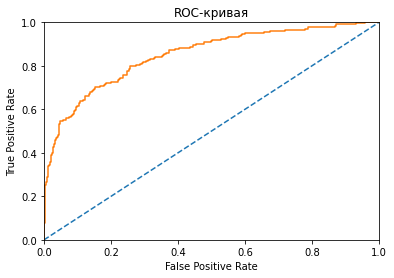

Auc_roc для константы на тестовой выборке 0.5
roc_auc_score для итоговой модели 0.7764801920183245


In [26]:
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()
target_allzero_predicion_constant = pd.Series(0, index=y_test.index)
auc_roc_reg=roc_auc_score(y_test,target_allzero_predicion_constant)
print ("Auc_roc для константы на тестовой выборке",auc_roc_reg)
print ("roc_auc_score для итоговой модели", roc_auc_score(y_test,best_pred_final))


Отлично, мы видим, что наша модель работает гораздо лучше, а ее качественные показатели попали в таргет.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Я бы посмотрел и на другие метрики константной модели здесь.
<font color = blue> Добавил roc auc       
</div>

### Выводы

* В полученном датасете в одном из полей отсутствовали значения. Изучив список было принятно решение заполнить пропуски медианным значением.
* На этапе валидации была выбрана модель "Случайный лес", т.к. ее показатели были значительно выше других моделей. F1 score составил 63.4%
* В ходе работы над моделью выяснилось, что целевой столбец содержит только 20% положительных ответов, в результате чего был использован метод upsample
* При тестировании на тестовой выборке модель также отлично справилась, f1 score получилось 60,2%

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Всё верно
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**
    
Спасибо за твой проект! Получилась неплохая работа. Мне было интересно следить за ходом мыслей и твоими решениями. Есть несколько важных моментов, которые необходимо улучшить. Их ты найдешь в разноцветных комментариях.
    
**Отмечу положительные моменты проекта🚀**
    
* Хорошее оформление, понятный код.
* Неплохая аргументация шагов и решений.
* Есть выводы.
    
**На что стоит обратить внимание🤔**
    
* По проекту сначала смотрим на модели без борьбы с дисбалансом.
* Затем исследуем хотя бы пару способов борьбы с дисбалансом. В каждом случае подбираем гиперпараметры.
* Я бы добавил обоснование, почему и какие метрики используем, как они соответствуют бизнес-задаче.
* Эти и остальные замечания я также написал по ходу проекта.
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
    
    
</div>



<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

По исправлениям все отлично.
    
По финальной метрике, как вижу, на тесте f1 ниже 0.59. Думаю, дело в гиперпараметрах. Попробуй что-то вроде глубины на 11 и количество эстиматоров 50-60.
    
    
**Желаю удачи и жду твой проект на повторное ревью!**😉
<font color = blue> На стадии валидации у дерева решений показатели были лучше, но на тестовой фазе, 0,6 достичь не удалось, т.к. там нет параметра естиматоры, поигрался с балансами классов, но больше 59.5 не получилось. В итоге применил случайный лес и получилось 63.1. Пришел к выводу, что дерево менее гибкое и если не прокнуло, то вряд ли исправится в конце, поэтому При аналогичных параметрах наверное стоит использовать лес, т.к. в нем можно настроить больше параметров, возможно ошибаюсь. В перспективе планирую использовать специальные инструменты по настройке гиперпараметров, циклом перебирать долговато получается.) Спасибо за ревью, было очень интересно и полезно.</div>



<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Ок, понял. Да, дальше в курсе будет про кросс-валидацию. 
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий к финальной проверке**

Спасибо за доработку. Критичных комментариев нет. 

Желаю удачи в дальнейшей учебе!

</div>
